In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc
import pathlib
import os

import signac

from scipy import optimize

In [2]:
from monk import nb, prep, pair, render, utils, grid, workflow
import freud

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"].append(r'\usepackage{xfrac}')

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'dt': 0.001, 'usteps': 1000, 'avail_seed': 17, 'temp_steps': 20, 'step_unit': 1000, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 20, '_status': {}}

['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp_0_475', 'temp_0_500']
0_275
['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp_0_475', 'temp_0_500']
0_300
['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp_0_475', 'temp_0_500']
0_325
['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp_0_475', 'temp_0_500']
0_350
['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp_0_475', 'temp_0_500']
0_375
['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp_0_475', 'temp_0_500']
0_400
['temp_0_275', 'temp_0_300', 'temp_0_325', 'temp_0_350', 'temp_0_375', 'temp_0_400', 'temp_0_425', 'temp_0_450', 'temp

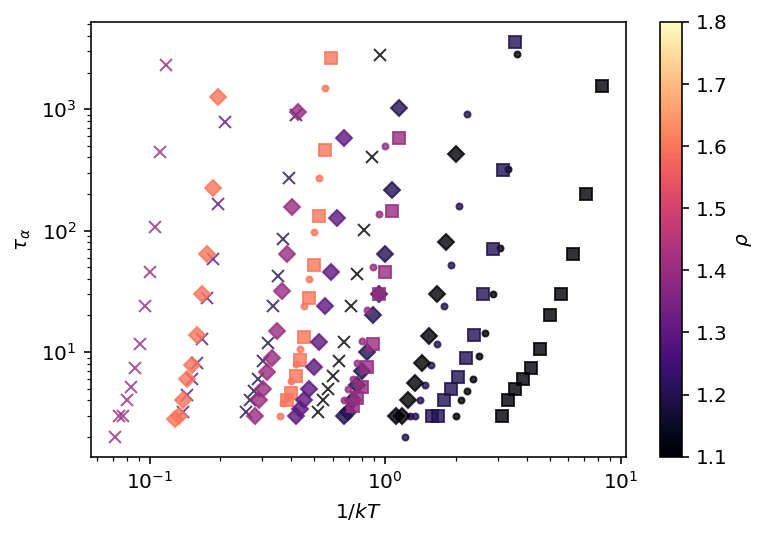

In [22]:

plt.figure()

_alpha = .8

markers = {"KA_LJ": ".", "KA_WCA": "s", ("KA_MLJ", 0.4): "x", ("KA_MLJ", 0.2): "D"}
cmap = cm.magma
norm = colors.Normalize(vmin=1.1, vmax=1.8)

for i, job in enumerate(project):

    # delta = job.sp["delta"]
    # if delta > 0.45:
    #     continue

    pot = job.sp["pot"]

    if isinstance(pot, str):
        pass
    else:
        pot = tuple(pot)

    marker = markers[pot]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                print(list(job.data["fine"].keys()))
                print(_temp_str)
                # try:
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 2:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # except:
                #     raise ValueError("No data found")
                
        print(temps, alphas)
        plt.plot(1/np.array(temps), np.array(alphas), marker, color=col, alpha=_alpha)

plt.xlabel(r"$1/kT$")
plt.ylabel(r"$\tau_{\alpha}$")
plt.yscale('log')
plt.xscale('log')
# plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")

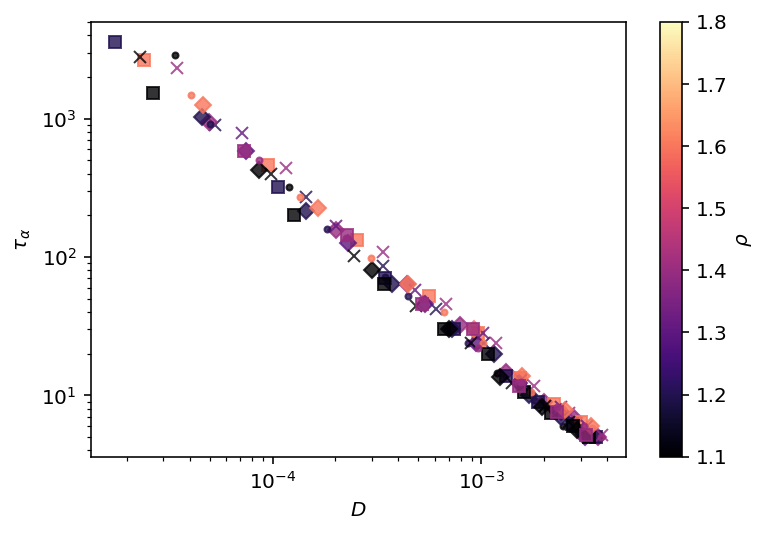

In [23]:

plt.figure()

_alpha = .8

markers = {"KA_LJ": ".", "KA_WCA": "s", ("KA_MLJ", 0.4): "x", ("KA_MLJ", 0.2): "D"}
cmap = cm.magma
norm = colors.Normalize(vmin=1.1, vmax=1.8)

for i, job in enumerate(project):

    # delta = job.sp["delta"]
    # if delta > 0.45:
    #     continue

    pot = job.sp["pot"]

    if isinstance(pot, str):
        pass
    else:
        pot = tuple(pot)

    marker = markers[pot]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                # print(list(job.data["fine"].keys()))
                # print(_temp_str)
                # try:
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 5:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # except:
                #     raise ValueError("No data found")
                
        # print(temps, alphas)
        plt.plot(np.array(Ds), np.array(alphas), marker, color=col, alpha=_alpha)

plt.ylabel(r"$\tau_{\alpha}$")
plt.xlabel(r"$D$")
# plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")
plt.yscale('log')
plt.xscale('log')

0.275 2860.0001358427107
0.300 320.0000151991844
0.325 72.0000034198165
0.350 30.00000142492354
0.375 14.400000683963299
0.400 9.200000436976552
0.425 6.000000284984708


TypeError: unhashable type: 'JSONAttrList'

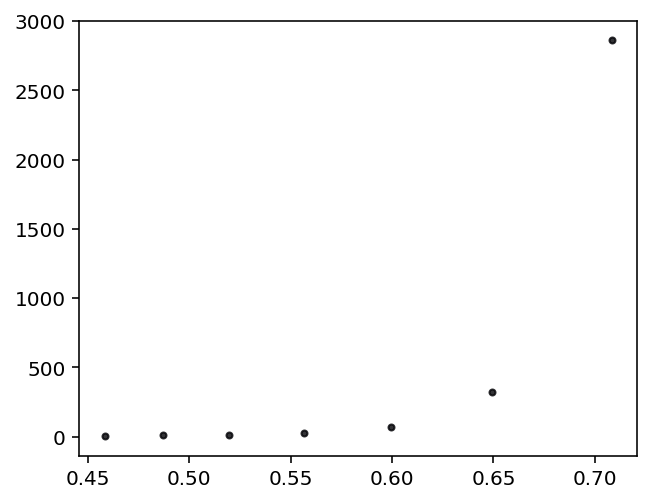

In [19]:
def vft(x, a, b, t):
    return np.log(a * np.exp(b/(x-t)))

plt.figure(figsize=(5,4))

for i, job in enumerate(project):

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 5:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, -0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = popt[2]
        # tg = np.min(temps)/2
        # print(popt, pcov)
        plt.plot(tg/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")

2860.0001358427107
[0.30746969 0.68133356 0.20068697] [[ 1.35181946e-03 -1.22539217e-03  1.03907006e-04]
 [-1.22539217e-03  1.16949884e-03 -1.02206378e-04]
 [ 1.03907006e-04 -1.02206378e-04  9.22986892e-06]]
0.22344846189300657
900.0000427477062
[0.12986801 7.28499066 1.58201684] [[ 0.0014134  -0.02891914  0.00237377]
 [-0.02891914  0.60703794 -0.05077466]
 [ 0.00237377 -0.05077466  0.00433217]]
1.825388472804356
940.0000446476042
[0.22771309 4.72392491 1.76667435] [[ 0.00320677 -0.02730663  0.00245899]
 [-0.02730663  0.24030218 -0.02213215]
 [ 0.00245899 -0.02213215  0.00208781]]
1.924487778968064
920.0000436976552
[0.21494061 1.18714192 0.30819161] [[ 1.17057277e-03 -2.78760881e-03  2.56184479e-04]
 [-2.78760881e-03  6.92768636e-03 -6.54145646e-04]
 [ 2.56184479e-04 -6.54145646e-04  6.36052486e-05]]
0.34785077929228164
3600.0001709908247
[0.41563533 0.82866697 0.18886308] [[ 1.79271766e-03 -1.59014272e-03  1.40223129e-04]
 [-1.59014272e-03  1.51142336e-03 -1.38190734e-04]
 [ 1.402231

(0.0, 1.0)

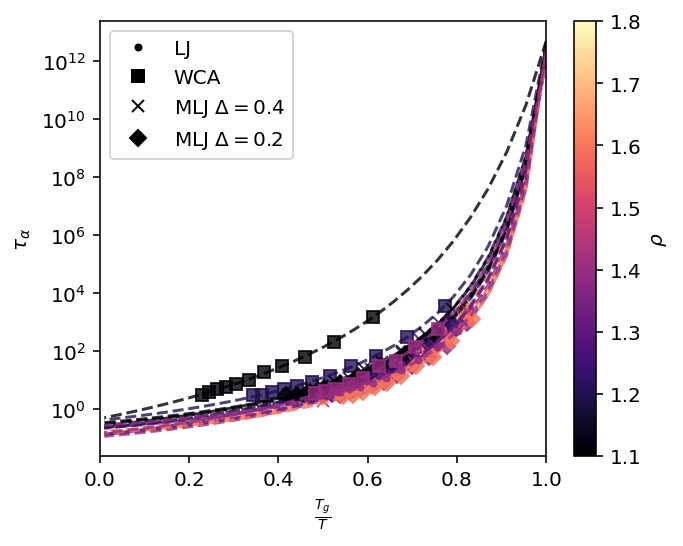

In [24]:
def vft(x, a, b, t):
    return a * np.exp(b/(x-t))

def log_vft(x, a, b, t):
    return np.log(vft(x, a, b, t))

def inv_vft(y, a, b, t):
    # y = a * np.exp(b/(x-t))
    # np.log(y) = np.log(a) + b/(x-t)
    # np.log(y) - np.log(a) = b/(x-t)
    # x - t = b/(np.log(y) - np.log(a))
    return b/np.log(y/a) + t

plt.figure(figsize=(5,4))

for i, job in enumerate(project):

    pot = job.sp["pot"]

    if isinstance(pot, str):
        pass
    else:
        pot = tuple(pot)

    if pot == "WCA":
        continue

    marker = markers[pot]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 2:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        print(np.max(alphas))
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(log_vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, 0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = inv_vft(popt[0]*10e12, *popt)
        # tg = np.min(temps)/2
        print(popt, pcov)
        x = np.geomspace(tg*1.0, tg*100, 100)
        y = log_vft(x, *popt)
        print(tg)
        plt.plot(tg/x, np.exp(y), "--", color=col, alpha=_alpha)
        plt.plot(tg/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")

lines = [
    plt.Line2D([0], [0], color='black', lw=0, marker="."),
    plt.Line2D([0], [0], color='black', lw=0, marker="s"),
    plt.Line2D([0], [0], color='black', lw=0, marker="x"),
    plt.Line2D([0], [0], color='black', lw=0, marker="D"),
]
plt.legend(lines, ["LJ", "WCA", r"MLJ $\Delta=0.4$", r"MLJ $\Delta=0.2$"], loc="best")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")

# plt.ylim(1e0, 1e4)
plt.xlim(0.0, 1.0)

KA_LJ
2860.0001358427107
[0.30746969 0.68133356 0.20068697] [[ 1.35181946e-03 -1.22539217e-03  1.03907006e-04]
 [-1.22539217e-03  1.16949884e-03 -1.02206378e-04]
 [ 1.03907006e-04 -1.02206378e-04  9.22986892e-06]]
0.22344846189300657
('KA_MLJ', 0.4)
900.0000427477062
[0.12986801 7.28499066 1.58201684] [[ 0.0014134  -0.02891914  0.00237377]
 [-0.02891914  0.60703794 -0.05077466]
 [ 0.00237377 -0.05077466  0.00433217]]
1.825388472804356
('KA_MLJ', 0.2)
940.0000446476042
[0.22771309 4.72392491 1.76667435] [[ 0.00320677 -0.02730663  0.00245899]
 [-0.02730663  0.24030218 -0.02213215]
 [ 0.00245899 -0.02213215  0.00208781]]
1.924487778968064
KA_LJ
920.0000436976552
[0.21494061 1.18714192 0.30819161] [[ 1.17057277e-03 -2.78760881e-03  2.56184479e-04]
 [-2.78760881e-03  6.92768636e-03 -6.54145646e-04]
 [ 2.56184479e-04 -6.54145646e-04  6.36052486e-05]]
0.34785077929228164
KA_WCA
KA_WCA
('KA_MLJ', 0.2)
580.0000275485218
[0.22904428 3.24248482 1.08679488] [[ 0.00247081 -0.01516977  0.00144255]
 

(0.1, 0.9)

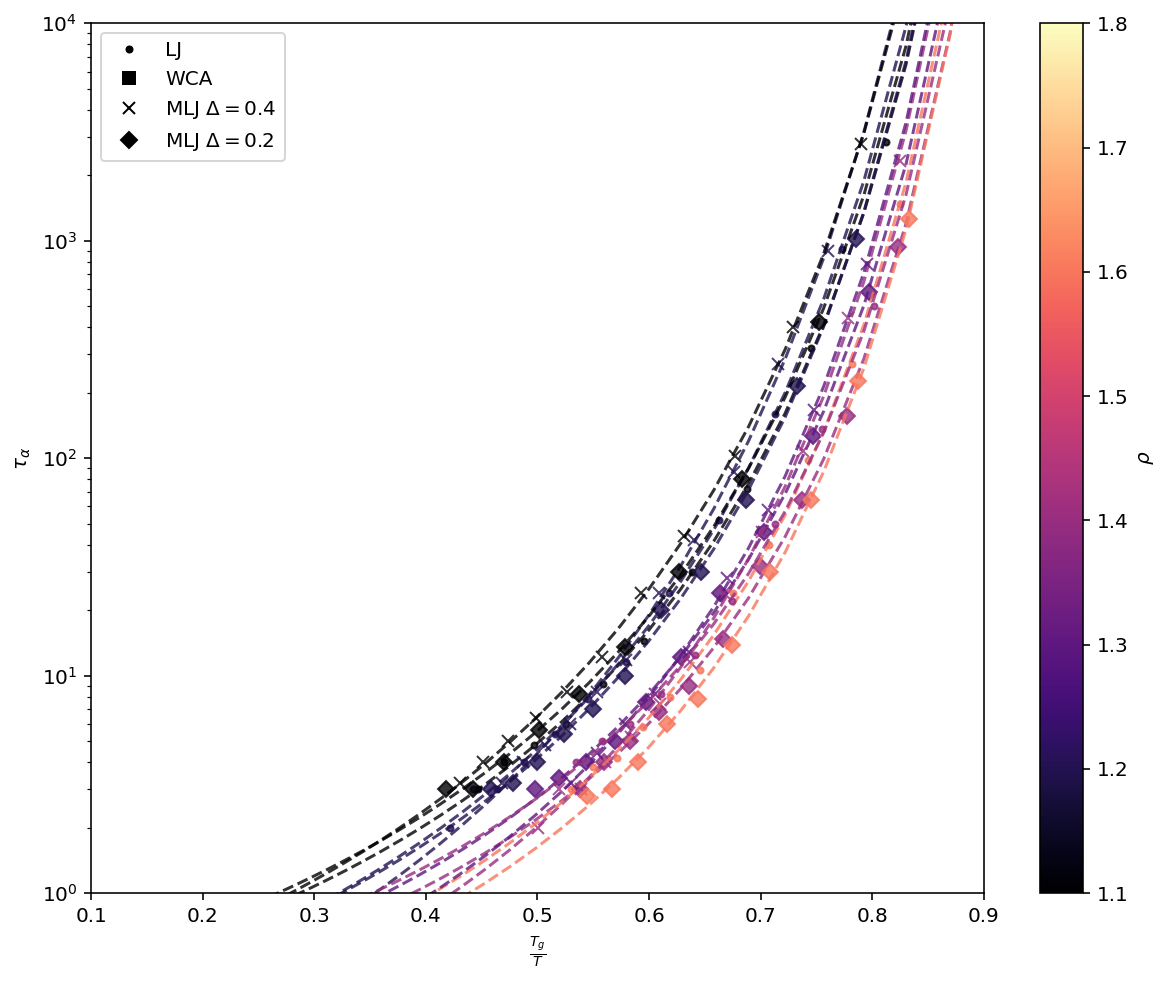

In [27]:
def vft(x, a, b, t):
    return a * np.exp(b/(x-t))

def log_vft(x, a, b, t):
    return np.log(vft(x, a, b, t))

def inv_vft(y, a, b, t):
    # y = a * np.exp(b/(x-t))
    # np.log(y) = np.log(a) + b/(x-t)
    # np.log(y) - np.log(a) = b/(x-t)
    # x - t = b/(np.log(y) - np.log(a))
    return b/np.log(y/a) + t

plt.figure(figsize=(10,8))

for i, job in enumerate(project):

    pot = job.sp["pot"]

    if isinstance(pot, str):
        pass
    else:
        pot = tuple(pot)
    print(pot)
    if pot == "KA_WCA":
        continue

    marker = markers[pot]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 2:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        print(np.max(alphas))
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(log_vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, 0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = inv_vft(popt[0]*10e12, *popt)
        # tg = np.min(temps)/2
        print(popt, pcov)
        x = np.geomspace(tg*1.0, tg*100, 100)
        y = log_vft(x, *popt)
        print(tg)
        plt.plot(tg/x, np.exp(y), "--", color=col, alpha=_alpha)
        plt.plot(tg/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")

lines = [
    plt.Line2D([0], [0], color='black', lw=0, marker="."),
    plt.Line2D([0], [0], color='black', lw=0, marker="s"),
    plt.Line2D([0], [0], color='black', lw=0, marker="x"),
    plt.Line2D([0], [0], color='black', lw=0, marker="D"),
]
plt.legend(lines, ["LJ", "WCA", r"MLJ $\Delta=0.4$", r"MLJ $\Delta=0.2$"], loc="best")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")

plt.ylim(1e0, 1e4)
plt.xlim(0.1, 0.9)